### set folder_name and `num_trials`
- `num_trials` and `threshold_shift` based on preprocessing alignment (see PreprocessLeverData notebooks) and can be found for each day's session in the Google sheets analysis log

In [1]:
name = 'ANM5'
session = '20240212_d1'
num_trials = 57
threshold_shift = 0.0

### imports

In [2]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import scipy.signal as signal
import pickle
import glob # find files in a directory
import re # regex for string parsing

from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.set_matplotlib_settings import set_matplotlib_settings
from common.set_matplotlib_settings import set_matplotlib_multiplot_settings2
from hit_movements.get_movement_thresholds import get_movement_thresholds
from common.select_trials import select_custom_hit_trials
from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.analyze_time_series import average_time_series
from path.get_aligned_movements import get_second_threshold_aligned_movements, get_first_threshold_aligned_movements

### Setup folders and plot settings

In [3]:
set_matplotlib_multiplot_settings2()

tone_discriminiation_matfile = '../Data_Copy/ToneDiscriminationData/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, arduino, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)
movement_baseline, movement_threshold, no_movement_threshold = get_movement_thresholds(params, respMTX, threshold_shift)

PreprocessLeverData_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
HitMovements_folder = "../Data_Copy/AnalysisData/"+name+"/HitMovements_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/Path_"+name+"_"+session+"/"
!mkdir {output_folder}

respMTX shape: (58, 7)
MTXTrialType shape: (1, 1)
number of trials: 58
movement_baseline for all trials should be the same:  0.6484848484848488
mvt threshold:  0.25 + movement_baseline =  0.8984848484848488
nomvt threshold:  0.15 + movement_baseline =  0.7984848484848488


### Calculate path aligned to second threshold

In [4]:
before_duration = 0.5
after_duration = 2.0
second_threshold_aligned_movements = get_second_threshold_aligned_movements(before_duration, after_duration, PreprocessLeverData_folder, HitMovements_folder, output_folder)
first_threshold_aligned_movements = get_first_threshold_aligned_movements(before_duration, after_duration, PreprocessLeverData_folder, HitMovements_folder, output_folder)

resolution_time = 0.005
mean_path_data, path_times, std_path_data, sem_path_data, var_path_data = average_time_series(first_threshold_aligned_movements, resolution_time)

path_variance_dx = np.median(np.diff(path_times))
cumulative_path_variance = np.trapz(var_path_data, dx=path_variance_dx)

np.save(output_folder+'mean_path_data', mean_path_data)
np.save(output_folder+'path_times', path_times)
np.save(output_folder+'std_path_data', std_path_data)
np.save(output_folder+'sem_path_data', sem_path_data)
np.save(output_folder+'var_path_data', var_path_data)

### Plot

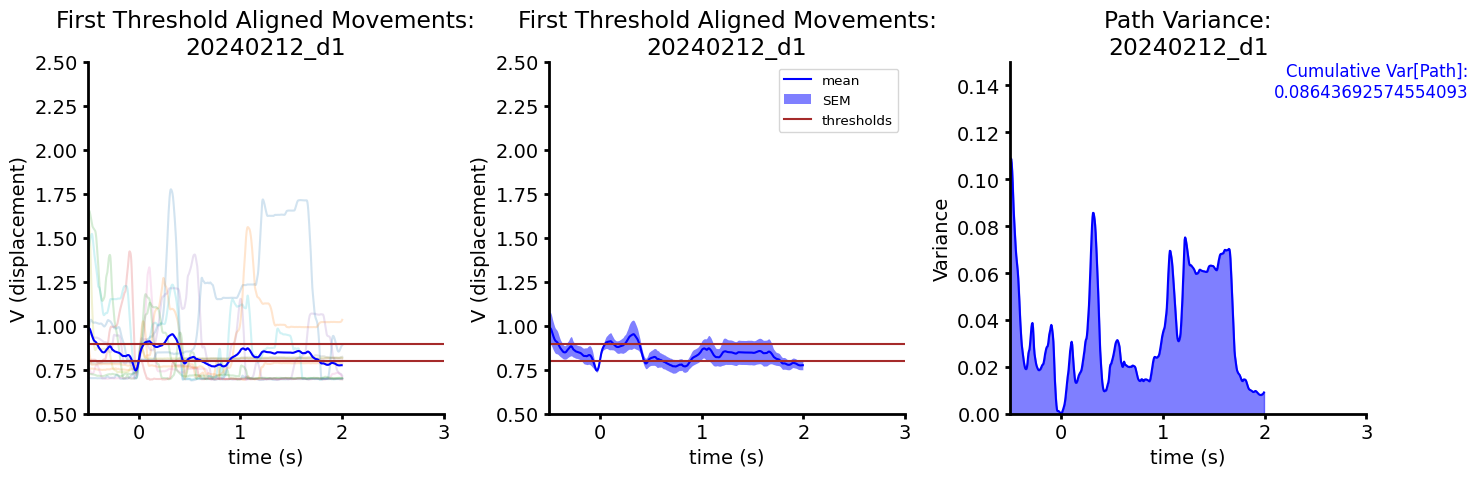

In [5]:
plt.subplot(1,3,1)
for first_threshold_aligned_movement in first_threshold_aligned_movements:
    plt.plot(first_threshold_aligned_movement[1], first_threshold_aligned_movement[0], alpha=0.2)
plt.plot(path_times, mean_path_data, color='blue')
plt.axhline(y=movement_baseline + no_movement_threshold, label='thresholds', color='brown')
plt.axhline(y=movement_baseline + movement_threshold, color='brown')
plt.xlabel("time (s)")
plt.ylabel("V (displacement)")
plt.ylim([0.5, 2.5])
plt.xlim([-0.5, 3])
plt.title("First Threshold Aligned Movements:\n"+session)

plt.subplot(1,3,2)
plt.plot(path_times, mean_path_data, color='blue', label='mean')
plt.fill_between(path_times, mean_path_data+sem_path_data, mean_path_data-sem_path_data, color='blue', alpha=0.5, label='SEM', zorder=2, linewidth=0.0)
plt.axhline(y=movement_baseline + no_movement_threshold, label='thresholds', color='brown')
plt.axhline(y=movement_baseline + movement_threshold, color='brown')
plt.ylim([0.5, 2.5])
plt.xlim([-0.5, 3])
plt.xlabel("time (s)")
plt.ylabel("V (displacement)")
plt.legend()
plt.title("First Threshold Aligned Movements:\n"+session)

plt.subplot(1,3,3)
plt.fill_between(path_times, 0, var_path_data, color='blue', alpha=0.5)
plt.plot(path_times, var_path_data, color='blue')
plt.ylim([0, 0.15])
plt.xlim([-0.5, 3])
plt.xlabel("time (s)")
plt.ylabel("Variance")
plt.title("Path Variance:\n"+session)
plt.text(4, 0.15, "Cumulative Var[Path]:\n"+ str(cumulative_path_variance), ha='right', va='top', fontsize=12, color='blue')

plt.savefig(output_folder+"plot_path_analysis.png")
plt.show()